In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

/data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
sys.path.append('../insight')
from archive import archive 
from insight_arch import Photoz_network
from insight import Insight_module
from utils import sigma68, nmad, plot_photoz
from scipy import stats

In [4]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

In [6]:
photoz_archive = archive(path = parent_dir, Qz_cut=1)
f, ferr, specz, specqz = photoz_archive.get_training_data()

In [100]:
f_test, ferr_test, specz_test = photoz_archive.get_testing_data()

In [74]:
df_test = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/NNphotozs/results/df1.csv', sep=',', header = 0, comment='#')

In [76]:
df_test

,VISmag,zs,z,zuncert,zwerr
0,23.103798,1.103000,1.077487,0.147231,-0.012132
1,22.471019,0.468800,0.416247,0.177303,-0.035780
2,21.853940,0.694600,0.639316,0.124684,-0.032623
3,22.005561,0.649200,0.628935,0.128350,-0.012288
4,22.204387,0.666900,0.611376,0.104980,-0.033309
...,...,...,...,...,...
12048,22.449399,0.690462,0.722806,0.123866,0.019133
12049,22.102501,0.915746,0.956847,0.117305,0.021454
12050,22.982543,0.721060,0.745688,0.180621,0.014309
12051,20.037661,0.345100,0.358207,0.070814,0.009744


In [77]:
def plot_nz(df, bins=np.arange(0,5,0.2)):
    kwargs=dict( bins=bins,alpha=0.5)
    plt.hist(df.zs.values, color='grey', ls='-' ,**kwargs)
    counts, _, =np.histogram(df.z.values, bins=bins)
    
    plt.plot((bins[:-1]+bins[1:])*0.5,counts, color ='purple')
    
    #plt.legend(fontsize=14)
    plt.xlabel(r'Redshift', fontsize=14)
    plt.ylabel(r'Counts', fontsize=14)
    plt.yscale('log')
    
    plt.show()
    

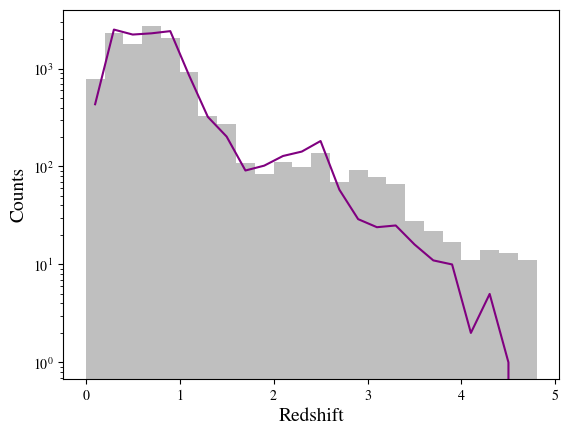

In [58]:
plot_nz(df_test)

In [68]:
def plot_photoz(df, nbins,xvariable,metric, type_bin='bin'):
    bin_edges = stats.mstats.mquantiles(df[xvariable].values, np.linspace(0.1,1,nbins))
    ydata,xdata = [],[]
    
    
    for k in range(len(bin_edges)-1):
        edge_min = bin_edges[k]
        edge_max = bin_edges[k+1]

        mean_mag =  (edge_max + edge_min) / 2
        
        if type_bin=='bin':
            df_plot = df[(df[xvariable] > edge_min) & (df[xvariable] < edge_max)]
        elif type_bin=='cum':
            df_plot = df[(df[xvariable] < edge_max)]
        else:
            raise ValueError("Only type_bin=='bin' for binned and 'cum' for cumulative are supported")


        xdata.append(mean_mag)
        if metric=='sig68':
            ydata.append(sigma68(df_plot.zwerr))
            ylab=r'$\sigma_{\rm NMAD} [\Delta z]$'
        elif metric=='bias':
            ydata.append(np.median(df_plot.zwerr))
            ylab=r'Median $[\Delta z]$'
        elif metric=='nmad':
            ydata.append(nmad(df_plot.zwerr))
            ylab=r'$\sigma_{\rm NMAD} [\Delta z]$'
        elif metric=='outliers':
            ydata.append(len(df_plot[np.abs(df_plot.zwerr)>0.15])/len(df_plot) *100)
            ylab=r'$\eta$ [%]'
            
    if xvariable=='VISmag':
        xlab='VIS'
    elif xvariable=='zs':
        xlab=r'$z_{\rm spec}$'
    elif xvariable=='z':
        xlab=r'$z$'

    plt.plot(xdata,ydata, ls = '-', marker = '.', color = 'navy',lw = 1, label = '')
    plt.ylabel(f'{ylab}', fontsize = 18)
    plt.xlabel(f'{xlab}', fontsize = 16)

    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    plt.grid(False)
    
    plt.show()
   

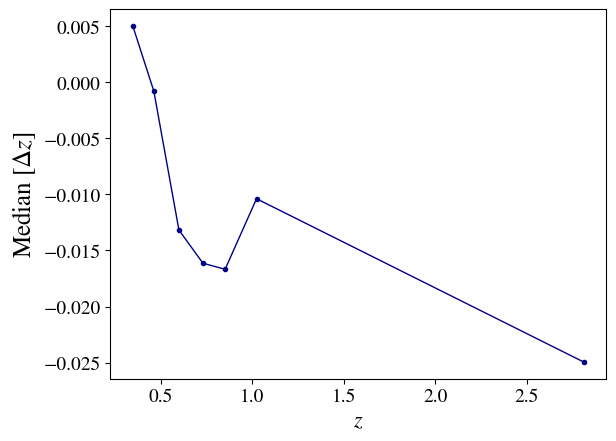

In [71]:
plot_photoz(df_test, 8,'z','bias', type_bin='bin')

In [109]:
nmad(df_test[df_test.VISmag<25].zwerr)

0.04460718134171633

In [110]:
df_test = df_test[df_test.VISmag<25]

In [111]:
len(df_test[np.abs(df_test.zwerr)>0.15])/len(df_test)

0.13433240659117107

In [112]:
torch.save(insight.model.state_dict(),'/data/astro/scratch/lcabayol/Euclid/NNphotozs/models/insight_v0.pt')
           
                  

In [113]:
df_test.to_csv('/data/astro/scratch/lcabayol/Euclid/NNphotozs/results/df0.csv', sep=',')

In [114]:
# Create a list of additional header lines
header_lines = [
    "# Training spect-zs with a strict quality cut",
    "#10 MDN components",
    "# For 300 epochs with lr0=1e-3 + 100 epochs with lr=1e-4",
    "# Date: 2023-07-26",
]

# Write DataFrame to a CSV file with custom header lines
with open('/data/astro/scratch/lcabayol/Euclid/NNphotozs/results/df0.csv', 'w') as f:
    for line in header_lines:
        f.write(line + '\n')
    df_test.to_csv(f, header=True, index=False, line_terminator='\n')


/tmp/ipykernel_678/2146862925.py:13: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  df_test.to_csv(f, header=True, index=False, line_terminator='\n')
